In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv('PEPE_1m_ta.csv')

In [68]:
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [69]:
df = df.set_index('date')

In [70]:
df = df.iloc[10000:]

In [73]:
nan_cols = df.columns[df.isna().any()]

print("有 NaN 的列为:")
print(nan_cols)

有 NaN 的列为:
Index(['MFI_14', 'EOM_14_100000000', 'CCI_20_0.015', 'DPO_20', 'UO_7_14_28',
       'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'SUPERTl_10_3.0', 'SUPERTs_10_3.0',
       'ICS_26'],
      dtype='object')


In [74]:
df = df.drop(columns=nan_cols)

In [75]:
print(df.isna().sum().sum())


0


In [87]:
df['target'] = df['return'].shift(-1)
df = df.iloc[:-1, :]

drop_cols = ['Unnamed: 0', 'date']
feature_cols = [c for c in df.columns if c not in drop_cols + ['target']]

X = df[feature_cols].values
y = df['target'].values

N = len(df)
train_size = int(N * 0.7)
test_size = int(N * 0.15)
val_size = N - train_size - test_size

train_end = train_size
test_end = train_size + test_size

X_train = X[:train_end]
y_train = y[:train_end]

X_test = X[train_end:test_end]
y_test = y[train_end:test_end]

X_val = X[test_end:]
y_val = y[test_end:]

print("X_train NaNs:", np.isnan(X_train).sum(), "y_train NaNs:", np.isnan(y_train).sum())
print("X_test NaNs:", np.isnan(X_test).sum(), "y_test NaNs:", np.isnan(y_test).sum())
print("X_val NaNs:", np.isnan(X_val).sum(), "y_val NaNs:", np.isnan(y_val).sum())

# 标准化(2D数据)
feature_scaler = StandardScaler()
feature_scaler.fit(X_train)
X_train_scaled = feature_scaler.transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
X_val_scaled = feature_scaler.transform(X_val)

# 创建一个函数来生成长度为seq_length的滚动窗口特征和相应的目标值
def create_rolling_features(X, y, seq_length=5):
    X_rolling = []
    y_rolling = []
    for i in range(len(X) - seq_length + 1):
        X_rolling.append(X[i:i+seq_length, :])
        # 这里的目标值对应的是窗口的最后一个时间点的预测值
        y_rolling.append(y[i+seq_length-1])
    return np.array(X_rolling), np.array(y_rolling)

seq_length = 60
X_train_lstm, y_train_lstm = create_rolling_features(X_train_scaled, y_train, seq_length)
X_test_lstm, y_test_lstm = create_rolling_features(X_test_scaled, y_test, seq_length)
X_val_lstm, y_val_lstm = create_rolling_features(X_val_scaled, y_val, seq_length)

print("X_train_lstm shape:", X_train_lstm.shape) # (train_samples-59, 60, features)
print("y_train_lstm shape:", y_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_test_lstm shape:", y_test_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("y_val_lstm shape:", y_val_lstm.shape)

X_train NaNs: 0 y_train NaNs: 0
X_test NaNs: 0 y_test NaNs: 0
X_val NaNs: 0 y_val NaNs: 0
X_train_lstm shape: (578360, 60, 76)
y_train_lstm shape: (578360,)
X_test_lstm shape: (123888, 60, 76)
y_test_lstm shape: (123888,)
X_val_lstm shape: (123889, 60, 76)
y_val_lstm shape: (123889,)


In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [90]:
seq_length = X_train_lstm.shape[1]
feature_dim = X_train_lstm.shape[2]

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"),
             layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):  # 为training参数添加默认值None
        attn_output = self.att(inputs, inputs, training=training)  # 如果需要，传入training参数
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

embed_dim = feature_dim   # 可以选择与特征数相同的维度
num_heads = 4
ff_dim = 64
dropout_rate = 0.1

learning_rate = 0.001
batch_size = 256
epochs = 10

inputs = layers.Input(shape=(seq_length, feature_dim))
x = TransformerEncoder(embed_dim, num_heads, ff_dim, rate=dropout_rate)(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Transformer Model Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 测试集评估
y_pred = model.predict(X_test_lstm)
test_loss = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
mae = mean_absolute_error(y_test_lstm, y_pred)
r2 = r2_score(y_test_lstm, y_pred)

print("Test Loss (MSE):", test_loss)
print("Test MAE:", mae)
print("Test R²:", r2)

TypeError: missing a required argument: 'training'

In [81]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test_lstm)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MAE:", mae)
print("Test R²:", r2)

3874/3874 ━━━━━━━━━━━━━━━━━━━━ 4s 873us/step
Test MAE: 0.0014940622176411926
Test R²: -0.09834285481630456


3874/3874 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step


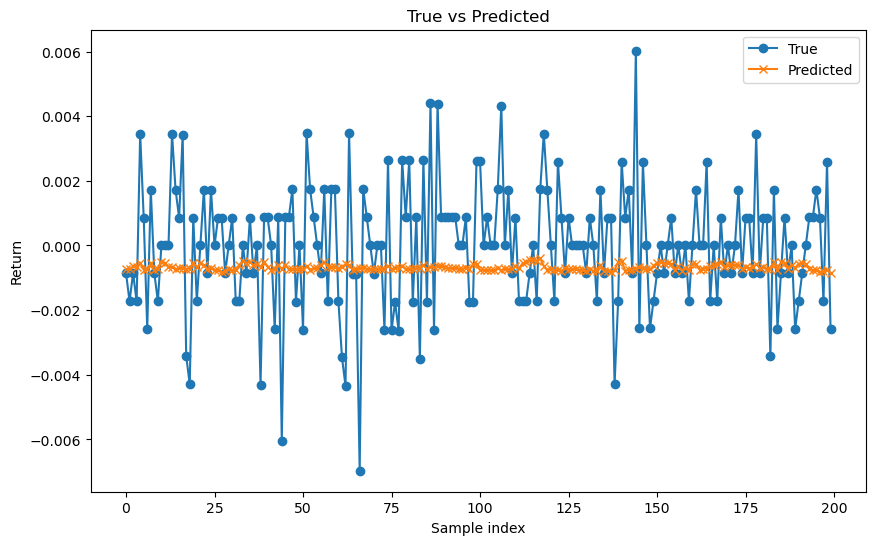

In [82]:
y_pred = model.predict(X_test_lstm)

plt.figure(figsize=(10,6))
plt.plot(y_test[:200], label='True', marker='o')  # 显示前200个点为例
plt.plot(y_pred[:200], label='Predicted', marker='x')
plt.title('True vs Predicted')
plt.xlabel('Sample index')
plt.ylabel('Return')
plt.legend()
plt.show()

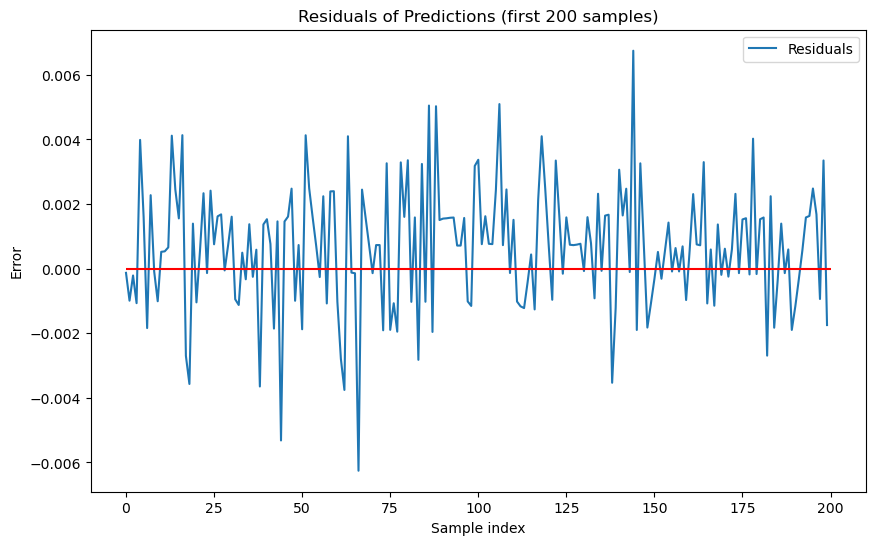

In [83]:
residuals = y_test - y_pred.ravel()
plt.figure(figsize=(10,6))
plt.plot(residuals[:200], label='Residuals')
plt.hlines(0, 0, 200, colors='r')
plt.title('Residuals of Predictions (first 200 samples)')
plt.xlabel('Sample index')
plt.ylabel('Error')
plt.legend()
plt.show()
